## Iterative methods

To solve the linear system given $A\mathbf{x} = \mathbf{b}$,
we'll implement three iterative methods: Jacobi, Gauss-Seidel, and Successive Over Relaxation (SOR). 

In [18]:
import numpy as np

A = np.array([[ 4, -1,  0], 
              [-1,  4, -1], 
              [ 0, -1,  4]])
b = np.array([ 2,  4, 10])
x0 = np.zeros(3)
eps = 10**-7

We will:

- Examine whether the sequence of vectors generated by each method's fixed point iteration function does coverge to the analytic solution $\mathbf{x} = (1,2,3)^T$. 
- Take $\mathbf{x}_0 = (0,0,0)^T$ as our initial term and proceed until the $l_\infty$ norm of the difference between two successive approximations is less than $\varepsilon = 10^{-7}$.
- Time the convergence of each method with python's ``%%timeit`` magic function.

### Jacobi method 

This method simultaneously computes all entries in the output vector with matrix multiplication.

The function `jacobi` takes as input

- `A`, a 2-D square array
- `b` and `x0`, 1-D arrays

and outputs (the tuple)

- `x1`, a 1-D array that succeeds `x0` in approximating `b`
- `np.linalg.norm(x1 - x0, ord=np.inf)`, the $l_\infty$ norm of `x1-x0` 

In [19]:
def jacobi(A,b,x0, *args):
    U = np.triu(A,1)
    D = np.diag(A)
    L = np.tril(A,-1)
    x1 = (1/D) * (b - np.matmul((L+U),x0))
    return x1, np.linalg.norm(x1 - x0, ord=np.inf)

We now iterately change the state of `x_approx` by looping calls to the `jacobi` function while `interstep` is greater than $\varepsilon$.

In [20]:
x_approx = x0
interstep = eps+1 #must dominate eps to enter while loop
while interstep > eps:
    x_approx,interstep = jacobi(A,b,x_approx)
x_approx

array([0.99999997, 1.99999994, 2.99999997])

Lastly, we time the execution of the entire cell, and take the average of the 3 best results.

In [21]:
%%timeit
x_approx = x0
interstep = eps+1
while interstep > eps:
    x_approx,interstep = jacobi(A,b,x_approx)

1000 loops, best of 3: 1.22 ms per loop


### Gauss-Seidel method

In contrast to the Jacobi method, the Gauss-Seidel method computes each entry `x1[i]` of the output vector in succession.

In [22]:
def gauss_seidel(A,b,x0, *args):
    n = len(x0)
    x1=np.zeros(n)
    for i in range(n):
        new = np.sum(A[i,:i] * x1[:i])
        old = np.sum(A[i,i+1:] * x0[i+1:])
        x1[i] = (1 / A[i,i]) * (b[i] - new - old)
    return x1, np.linalg.norm(x1 - x0, ord=np.inf)

We update `x_approx` in a similar a while loop.

In [23]:
x_approx = x0
interstep = eps+1
while interstep > eps:
    x_approx,interstep = gauss_seidel(A,b,x_approx)
x_approx

array([0.99999999, 1.99999999, 3.        ])

And we'll time it.

In [24]:
%%timeit
x_approx = x0
interstep = eps+1
while interstep > eps:
    x_approx,interstep = gauss_seidel(A,b,x_approx)

1000 loops, best of 3: 986 µs per loop


### Successive over relaxation

Successive over relaxation generalizes the Gauss-Seidel method, and as such the `SOR` function requires an additional input `omega`. 

We choose the optimal parameter $\omega = 2/(1+\sqrt{7/8})$.

In [25]:
def SOR(A,b,x0,omega):
    n = len(x0)
    x1=np.zeros(n)
    for i in range(n):
        jaterm = (1-omega) * x0[i]
        gsnew = np.sum(A[i,:i] * x1[:i])
        gsold = np.sum(A[i,i+1:] * x0[i+1:])
        gsterm = (omega / A[i,i]) * (b[i] - gsnew - gsold)
        x1[i] = jaterm + gsterm
    return x1, np.linalg.norm(x1-x0, ord=np.inf)

In [26]:
omega = 2/(1+np.sqrt(7/8))
x_approx = x0
interstep = eps+1
while interstep > eps:
    x_approx,interstep = SOR(A,b,x_approx,omega)
x_approx

array([1., 2., 3.])

In [27]:
%%timeit
x_approx = x0
interstep = eps+1
while interstep > eps:
    x_approx,interstep = SOR(A,b,x_approx,omega)

1000 loops, best of 3: 811 µs per loop


### Error analysis

The function `capture_error` logs the $l_\infty$ norm of the error as each `method` runs until the desired accuracy is achieved.

In [28]:
def capture_error(method,A,b,x_approx,omega,x_exact,eps):
    error = np.array([np.linalg.norm(x_approx - x_exact, ord=np.inf)])
    while error[-1] > eps:
        x_approx = method(A,b,x_approx,omega)[0]
        error = np.append(error,\
                np.linalg.norm(x_approx - x_exact, ord=np.inf))
    return error

We plot each method's error by iteration, and summarize.

method | iterations required | runtime
--- | --- | ---
jacobi | 17 | 1130 µs
gauss_seidel | 10 | 907 µs
SOR | 7 | 791 µs

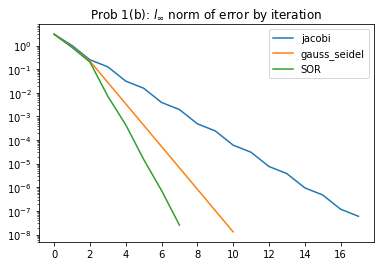

In [30]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
ax = plt.figure().gca()

plt.title('Prob 1(b): $l_\infty$ norm of error by iteration')
x_exact = np.array([1,2,3])
for method in [jacobi,gauss_seidel,SOR]:
    ax.semilogy(capture_error(method,A,b,x0,omega,x_exact,eps),\
        label=method.__name__)
    
plt.legend()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()